# **1.0 AutoEncoder Architecture**

* **CUHK Face Sketch Database**

In [162]:
#@title **1.1. Prepare Datasets**


# Import libraries
import os
import sys
import gdown
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as K
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, optimizers, metrics
from tensorflow.keras.optimizers import *
from tensorflow.keras.losses import *
from tensorflow.keras.layers import Dense, Flatten, Reshape, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.utils import plot_model
from zipfile import ZipFile
from PIL import Image
import urllib.request


# Set seed
np.random.seed(88)
tf.random.set_seed(88)

# Download and extract the dataset
urllib.request.urlretrieve("http://mmlab.ie.cuhk.edu.hk/archive/sketchdatabase/CUHK/training_88/Original_Images/CUHK_training_photo.zip", "train_photo.zip")
with ZipFile("train_photo.zip", "r") as zip_ref:
    zip_ref.extractall("train_photo")

urllib.request.urlretrieve("http://mmlab.ie.cuhk.edu.hk/archive/sketchdatabase/CUHK/training_88/Original_Images/CUHK_training_sketch.zip", "train_sketch.zip")
with ZipFile("train_sketch.zip", "r") as zip_ref:
    zip_ref.extractall("train_sketch")

urllib.request.urlretrieve("http://mmlab.ie.cuhk.edu.hk/archive/sketchdatabase/CUHK/testing_100/Original_Images/CUHK_testing_photo.zip", "test_photo.zip")
with ZipFile("test_photo.zip", "r") as zip_ref:
    zip_ref.extractall("test_photo")

urllib.request.urlretrieve("http://mmlab.ie.cuhk.edu.hk/archive/sketchdatabase/CUHK/testing_100/Original_Images/CUHK_testing_sketch.zip", "test_sketch.zip")
with ZipFile("test_sketch.zip", "r") as zip_ref:
    zip_ref.extractall("test_sketch")

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Found 88 files belonging to 1 classes.


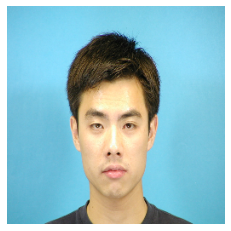

In [82]:
#@title **1.2.1. Training Dataset (Photos)**


# There are a total of 188 instances for each of the two datasets (photos & sketches).
# The training set uses 88 instances for both datasets.

# Checking contents of the training dataset (Photos)
dataset_train_photo = K.preprocessing.image_dataset_from_directory(
"train_photo/photo", label_mode=None, image_size=(256, 256), batch_size=32
)

dataset_train_photo = dataset_train_photo.map(lambda x: x / 255.0)

for x in dataset_train_photo:
    plt.axis("off")
    plt.imshow((x.numpy() * 255).astype("int32")[0])
    break

Found 88 files belonging to 1 classes.


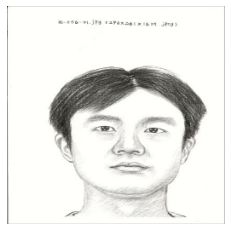

In [ ]:
#@title **1.2.2. Training Dataset (Sketches)**


# Checking contents of the training dataset (Sketches)
dataset_train_sketch = K.preprocessing.image_dataset_from_directory(
"train_sketch/sketch", label_mode=None, image_size=(256, 256), batch_size=32
)

dataset_train_sketch = dataset_train_sketch.map(lambda x: x / 255.0)

for x in dataset_train_sketch:
    plt.axis("off")
    plt.imshow((x.numpy() * 255).astype("int32")[0])
    break

Found 100 files belonging to 1 classes.


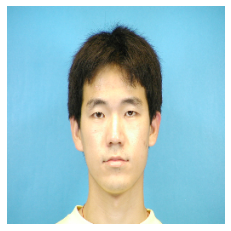

In [83]:
#@title **1.3.1. Testing Dataset (Photos)**


# There are a total of 188 instances for each of the two datasets (photos & sketches).
# The testing set uses 100 instances for both datasets.

# Checking contents of the testing dataset (Photos)
dataset_test_photo = K.preprocessing.image_dataset_from_directory(
"test_photo/photo", label_mode=None, image_size=(256, 256), batch_size=32
)

dataset_test_photo = dataset_test_photo.map(lambda x: x / 255.0)

for x in dataset_test_photo:
    plt.axis("off")
    plt.imshow((x.numpy() * 255).astype("int32")[0])
    break

Found 100 files belonging to 1 classes.


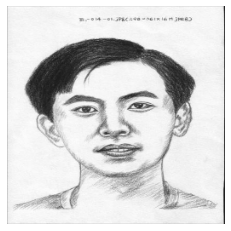

In [ ]:
#@title **1.3.2. Testing Dataset (Sketches)**


# Checking contents of the testing dataset (Sketches)
dataset_test_sketch = K.preprocessing.image_dataset_from_directory(
"test_sketch/sketch", label_mode=None, image_size=(256, 256), batch_size=32
)

dataset_test_sketch = dataset_test_sketch.map(lambda x: x / 255.0)

for x in dataset_test_sketch:
    plt.axis("off")
    plt.imshow((x.numpy() * 255).astype("int32")[0])
    break

In [163]:
#@title **1.4. Load Datasets**


def load_images(directory):
    images = []
    for root, dirs, files in os.walk(directory):
        if 'photo' in root.lower() or 'sketch' in root.lower():
            files = sorted(files)  # sort the list of filenames
            for filename in files:
                if filename.lower().endswith(".jpg"):
                    img_path = os.path.join(root, filename)
                    img = Image.open(img_path).convert('RGB') # L = Grey scale, RGB = RGB
                    img = img.resize((256, 256))
                    img_array = np.array(img)
                    img_array = img_array.reshape(256, 256, 3)  # 1 = Grey scale, 3 = RGB (Red, Green, Blue)
                    images.append(img_array)
    return images


# Load the images and preprocess them
x_train_photo = np.array(load_images("train_photo"))
x_test_photo = np.array(load_images("test_photo"))
y_train_sketch = np.array(load_images("train_sketch"))
y_test_sketch = np.array(load_images("test_sketch"))

# Convert the pixel values to floats between 0 and 1
x_train_photo = x_train_photo.astype('float32') / 255.
x_test_photo = x_test_photo.astype('float32') / 255.
y_train_sketch = y_train_sketch.astype('float32') / 255.
y_test_sketch = y_test_sketch.astype('float32') / 255.


print(f"Training dataset (Photo): {x_train_photo.shape}", f"Testing dataset (Photo): {x_test_photo.shape}")
print(f"Training dataset (Sketch): {y_train_sketch.shape}", f"Testing dataset (Sketch): {y_test_sketch.shape}")

Training dataset (Photo): (88, 256, 256, 3) Testing dataset (Photo): (100, 256, 256, 3)
Training dataset (Sketch): (88, 256, 256, 3) Testing dataset (Sketch): (100, 256, 256, 3)


In [164]:
#@title **1.5.1. Encoder**


class Encoder(K.layers.Layer):
    def __init__(self, filters):
        super(Encoder, self).__init__()
        self.conv1 = Conv2D(filters=filters[0], kernel_size=3, strides=1, activation='relu', padding='same')
        self.conv2 = Conv2D(filters=filters[1], kernel_size=3, strides=1, activation='relu', padding='same')
        self.conv3 = Conv2D(filters=filters[2], kernel_size=3, strides=1, activation='relu', padding='same')
        self.pool = MaxPooling2D((2, 2), padding='same')
               
    
    def call(self, input_features):
        x = self.conv1(input_features)
        #print("Ex1", x.shape)
        x = self.pool(x)
        #print("Ex2", x.shape)
        x = self.conv2(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = self.pool(x)
        return x

In [165]:
#@title **1.5.2. Decoder**


class Decoder(K.layers.Layer):
    def __init__(self, filters):
        super(Decoder, self).__init__()
        self.conv1 = Conv2D(filters=filters[2], kernel_size=3, strides=1, activation='relu', padding='same')
        self.conv2 = Conv2D(filters=filters[1], kernel_size=3, strides=1, activation='relu', padding='same')
        self.conv3 = Conv2D(filters=filters[0], kernel_size=3, strides=1, activation='relu', padding='same')
        self.conv4 = Conv2D(3, 3, activation='sigmoid', padding='same')
        self.upsample = UpSampling2D((2, 2))
  
    def call(self, encoded):
        x = self.conv1(encoded)
        #print("dx1", x.shape)
        x = self.upsample(x)
        #print("dx2", x.shape)
        x = self.conv2(x)
        x = self.upsample(x)
        x = self.conv3(x)
        x = self.upsample(x)
        return self.conv4(x)

In [166]:
#@title **1.5.3. Noise Parameter**


Noise = 1 #@param {type:"slider", min:0, max:1, step:0.1}

noise = Noise

x_train_noisy = x_train_photo + noise * np.random.normal(loc=0.0, scale=1.0, size=x_train_photo.shape)
x_test_noisy = x_test_photo + noise * np.random.normal(loc=0.0, scale=1.0, size=x_test_photo.shape)

x_train_noisy = np.clip(x_train_noisy, 0, 1)
x_test_noisy = np.clip(x_test_noisy, 0, 1)

x_train_noisy = x_train_noisy.astype('float32')
x_test_noisy = x_test_noisy.astype('float32')


In [167]:
#@title **1.6.1. AutoEncoder**


class Autoencoder(K.Model):
    def __init__(self, filters_encoder, filters_decoder):
        super(Autoencoder, self).__init__()
        self.loss = []
        self.encoder = Encoder(filters_encoder)
        self.decoder = Decoder(filters_decoder)


    def call(self, input_features):
        #print(input_features.shape)
        encoded = self.encoder(input_features)
        #print(encoded.shape)
        reconstructed = self.decoder(encoded)
        #print(reconstructed.shape)
        return reconstructed

In [168]:
#@title **1.6.2. Filters for Encoder & Decoder**


filter_encoder_0 = 64 #@param {type:"slider", min:8, max:256, step:2}
filter_encoder_1 = 32 #@param {type:"slider", min:8, max:256, step:2}
filter_encoder_2 = 16 #@param {type:"slider", min:8, max:256, step:2}

filters_en = [filter_encoder_0, filter_encoder_1, filter_encoder_2]


filter_decoder_0 = 16 #@param {type:"slider", min:8, max:256, step:2}
filter_decoder_1 = 32 #@param {type:"slider", min:8, max:256, step:2}
filter_decoder_2 = 64 #@param {type:"slider", min:8, max:256, step:2}

filters_de = [filter_decoder_0, filter_decoder_1, filter_decoder_2]


model = Autoencoder(filters_en, filters_de)

In [ ]:
#@title **1.7.1. Model 1 Evaluation: (Noise = 1.0, Batch Size = 1, Epochs = 100 | Loss Function = 'MSE', Optimizer = 'Adam')**


random.seed(88)

# Parameters
Noise = 1 #@param {type:"slider", min:0, max:1, step:0.1}
BATCH_SIZE = 1 #@param {type:"slider", min:1, max:200, step:1}
EPOCHS = 100 #@param {type:"slider", min:1, max:100, step:1}
noise = Noise
batch_size = BATCH_SIZE
max_epochs = EPOCHS


# Define the noise parameter into a function
def add_noise(x_train_photo, x_test_photo, noise):
    x_train_noisy = x_train_photo + noise * np.random.normal(loc=0.0, scale=1.0, size=x_train_photo.shape)
    x_test_noisy = x_test_photo + noise * np.random.normal(loc=0.0, scale=1.0, size=x_test_photo.shape)

    x_train_noisy = np.clip(x_train_noisy, 0, 1)
    x_test_noisy = np.clip(x_test_noisy, 0, 1)
    
    x_train_noisy = x_train_noisy.astype('float32')
    x_test_noisy = x_test_noisy.astype('float32')
    
    return x_train_noisy, x_test_noisy


# Parameters for the loss function, optimizer & metrics
optimizer = 'Adam'
loss_fn = 'MSE' # Mean Squared Error
metrics = 'Accuracy'

# Define a function where it outputs the average loss values
def train_model(model, x_train_noisy, x_train_photo, x_test_noisy, x_test_photo, max_epochs, batch_size, optimizer, loss_fn, metrics):

    # Add noise to the images
    x_train_noisy, x_test_noisy = add_noise(x_train_photo, x_test_photo, noise)

    # Compile the model
    model.compile(optimizer=optimizer, loss=loss_fn, metrics=metrics)

    # Fit the model
    m1 = model.fit(x_train_noisy,
                        x_train_photo,
                        validation_data=(x_test_noisy, x_test_photo),
                        epochs=max_epochs,
                        batch_size=batch_size,
                        verbose=0) # Prevent the lines of Epochs being displayed
                        
    # Compute average metrics scores over the training and testing datasets
    mse_loss = sum(m1.history['loss']) / len(m1.history['loss'])
    mse_val_loss = sum(m1.history['val_loss']) / len(m1.history['val_loss'])
    avg_accuracy = sum(m1.history['Accuracy']) / len(m1.history['Accuracy'])
    avg_val_accuracy = sum(m1.history['val_Accuracy']) / len(m1.history['val_Accuracy'])
    
    # Return average values & metrics scores for training & testing datasets
    return mse_loss, mse_val_loss, m1.history['loss'], m1.history['val_loss'], avg_accuracy, avg_val_accuracy, m1.history['Accuracy'], m1.history['val_Accuracy']


mse_loss, mse_val_loss, loss, val_loss, avg_accuracy, avg_val_accuracy, Accuracy, val_Accuracy = train_model(model, x_train_noisy, x_train_photo, x_test_noisy, x_test_photo, max_epochs, batch_size, optimizer, loss_fn, metrics)

mse_loss_m1 = round(mse_loss * 100, 3)
mse_val_loss_m1 = round(mse_val_loss * 100, 3)
avg_accuracy_m1 = round(avg_accuracy * 100, 3)
avg_val_accuracy_m1 = round(avg_val_accuracy * 100, 3)

# Print the average values in percentage(%) and rounded to 3 decimal points
print(f"Average Training Loss (MSE): {mse_loss_m1} %\n")
print(f"Average Validation Loss (MSE): {mse_val_loss_m1} %\n")
print(f"Average Training Accuracy: {avg_accuracy_m1} %\n")
print(f"Average Validation Accuracy: {avg_val_accuracy_m1} %\n")

print(f"\nParameters Used: \nNoise = {noise} \nBatch Size = {batch_size} \nEpochs = {max_epochs} \nOptimizer = {optimizer} \nLoss Function = {loss_fn} \nMetrics = {metrics}")


Average Training Loss (MSE): 0.37 %

Average Validation Loss (MSE): 0.451 %

Average Training Accuracy: 95.05 %

Average Validation Accuracy: 95.04 %


Parameters Used: 
Noise = 1 
Batch Size = 1 
Epochs = 100 
Optimizer = Adam 
Loss Function = MSE 
Metrics = Accuracy


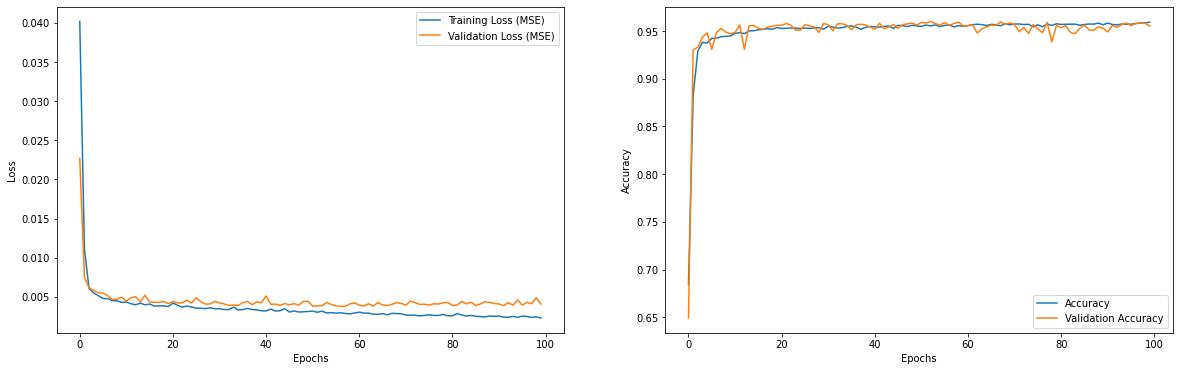

In [ ]:
#@title **1.7.2. Line Graphs of Model 1 Performance**


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

ax1.plot(loss, label='Training Loss (MSE)')
ax1.plot(val_loss, label='Validation Loss (MSE)')
ax1.legend()
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')

ax2.plot(Accuracy, label='Accuracy')
ax2.plot(val_Accuracy, label='Validation Accuracy')
ax2.legend()
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')

plt.show()

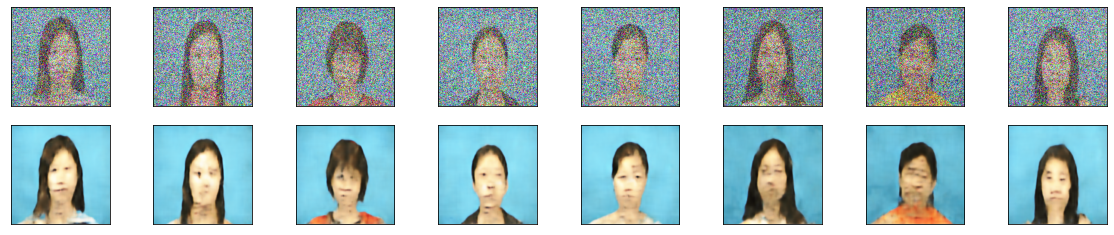

In [ ]:
#@title **1.7.3. Reconstructed Images (Noise = 1.0)**


n_images = 8  # How many images will be displayed
plt.figure(figsize=(20,4))

for index in range(n_images):
    # Display original
    ax = plt.subplot(2, n_images, index + 1)
    plt.imshow(x_test_noisy[index].reshape(256, 256, 3), cmap='jet')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n_images, index + 1 + n_images)
    plt.imshow(tf.reshape(model(x_test_noisy)[index], (256, 256, 3)), cmap='jet')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
#@title **1.8.1. Model 2 Evaluation: (Noise = 0.5, Batch Size = 1, Epochs = 100 | Loss Function = 'MSE', Optimizer = 'Adam')**


random.seed(88)

# Parameters
Noise = 0.5 #@param {type:"slider", min:0, max:1, step:0.1}
BATCH_SIZE = 1 #@param {type:"slider", min:1, max:200, step:1}
EPOCHS = 100 #@param {type:"slider", min:1, max:100, step:1}
noise = Noise
batch_size = BATCH_SIZE
max_epochs = EPOCHS


# Define the noise parameter into a function
def add_noise(x_train_photo, x_test_photo, noise):
    x_train_noisy = x_train_photo + noise * np.random.normal(loc=0.0, scale=1.0, size=x_train_photo.shape)
    x_test_noisy = x_test_photo + noise * np.random.normal(loc=0.0, scale=1.0, size=x_test_photo.shape)

    x_train_noisy = np.clip(x_train_noisy, 0, 1)
    x_test_noisy = np.clip(x_test_noisy, 0, 1)
    
    x_train_noisy = x_train_noisy.astype('float32')
    x_test_noisy = x_test_noisy.astype('float32')
    
    return x_train_noisy, x_test_noisy


# Parameters for the loss function, optimizer & metrics
optimizer = 'Adam'
loss_fn = 'MSE' # Mean Squared Error
metrics = 'Accuracy'

# Define a function where it outputs the average loss values
def train_model(model, x_train_noisy, x_train_photo, x_test_noisy, x_test_photo, max_epochs, batch_size, optimizer, loss_fn, metrics):

    # Add noise to the images
    x_train_noisy, x_test_noisy = add_noise(x_train_photo, x_test_photo, noise)

    # Compile the model
    model.compile(optimizer=optimizer, loss=loss_fn, metrics=metrics)

    # Fit the model
    m2 = model.fit(x_train_noisy,
                        x_train_photo,
                        validation_data=(x_test_noisy, x_test_photo),
                        epochs=max_epochs,
                        batch_size=batch_size,
                        verbose=0) # Prevent the lines of Epochs being displayed
                        
    # Compute average metrics scores over the training and testing datasets
    mse_loss = sum(m2.history['loss']) / len(m2.history['loss'])
    mse_val_loss = sum(m2.history['val_loss']) / len(m2.history['val_loss'])
    avg_accuracy = sum(m2.history['Accuracy']) / len(m2.history['Accuracy'])
    avg_val_accuracy = sum(m2.history['val_Accuracy']) / len(m2.history['val_Accuracy'])
    
    # Return average values & metrics scores for training & testing datasets
    return mse_loss, mse_val_loss, m2.history['loss'], m2.history['val_loss'], avg_accuracy, avg_val_accuracy, m2.history['Accuracy'], m2.history['val_Accuracy']


mse_loss, mse_val_loss, loss, val_loss, avg_accuracy, avg_val_accuracy, Accuracy, val_Accuracy = train_model(model, x_train_noisy, x_train_photo, x_test_noisy, x_test_photo, max_epochs, batch_size, optimizer, loss_fn, metrics)

mse_loss_m2 = round(mse_loss * 100, 3)
mse_val_loss_m2 = round(mse_val_loss * 100, 3)
avg_accuracy_m2 = round(avg_accuracy * 100, 3)
avg_val_accuracy_m2 = round(avg_val_accuracy * 100, 3)

# Print the average values in percentage(%) and rounded to 3 decimal points
print(f"Average Training Loss (MSE): {mse_loss_m2} %\n")
print(f"Average Validation Loss (MSE): {mse_val_loss_m2} %\n")
print(f"Average Training Accuracy: {avg_accuracy_m2} %\n")
print(f"Average Validation Accuracy: {avg_val_accuracy_m2} %\n")

print(f"\nParameters Used: \nNoise = {noise} \nBatch Size = {batch_size} \nEpochs = {max_epochs} \nOptimizer = {optimizer} \nLoss Function = {loss_fn} \nMetrics = {metrics}")


Average Training Loss (MSE): 0.174 %

Average Validation Loss (MSE): 0.245 %

Average Training Accuracy: 95.896 %

Average Validation Accuracy: 95.659 %


Parameters Used: 
Noise = 0.5 
Batch Size = 1 
Epochs = 100 
Optimizer = Adam 
Loss Function = MSE 
Metrics = Accuracy


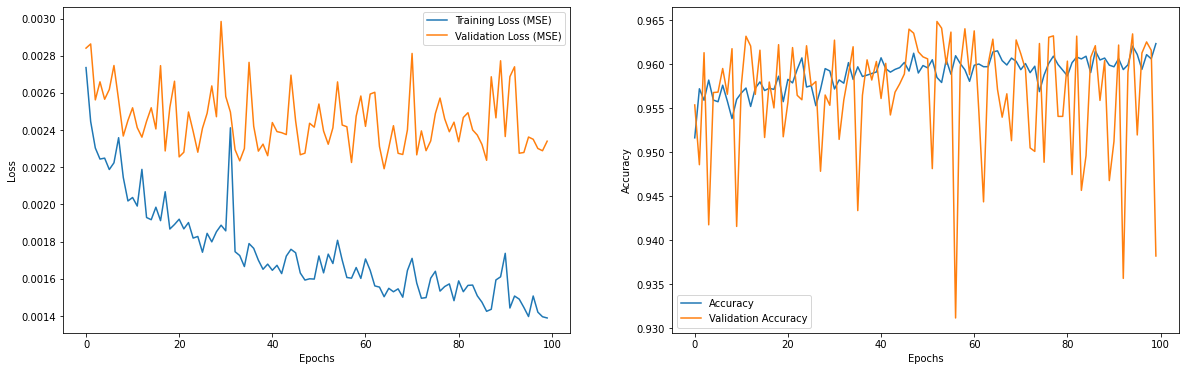

In [ ]:
#@title **1.8.2. Line Graphs of Model 2 Performance**


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

ax1.plot(loss, label='Training Loss (MSE)')
ax1.plot(val_loss, label='Validation Loss (MSE)')
ax1.legend()
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')

ax2.plot(Accuracy, label='Accuracy')
ax2.plot(val_Accuracy, label='Validation Accuracy')
ax2.legend()
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')

plt.show()

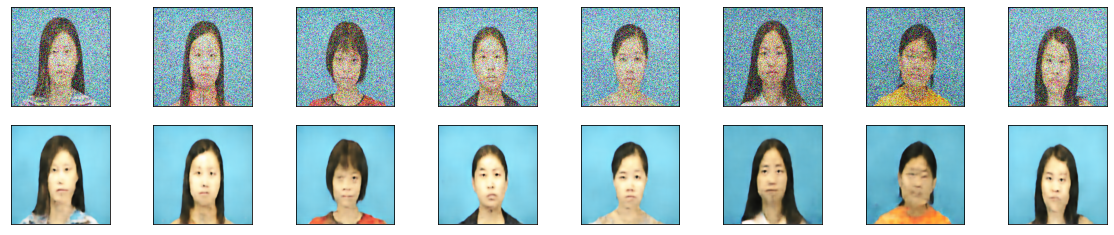

In [ ]:
#@title **1.8.3. Reconstructed Images (Noise = 0.5)**


n_images = 8  # How many images will be displayed
plt.figure(figsize=(20,4))

for index in range(n_images):
    # Display original
    ax = plt.subplot(2, n_images, index + 1)
    plt.imshow(x_test_noisy[index].reshape(256, 256, 3), cmap='jet')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n_images, index + 1 + n_images)
    plt.imshow(tf.reshape(model(x_test_noisy)[index], (256, 256, 3)), cmap='jet')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
#@title **1.8.4. Model Comparison: Model 2 Achieved a Higher Accuracy and Lower Loss-Rate, by Reducing the Noise Value from 1.0 to 0.5.**

# Create a DataFrame
df = pd.DataFrame({
    'Model 1': [
        f'Average Training Loss (MSE): {mse_loss_m1} %',
        f'Average Validation Loss (MSE): {mse_val_loss_m1} %',
        f'Average Training Accuracy: {avg_accuracy_m1} %',
        f'Average Validation Accuracy: {avg_val_accuracy_m1} %'
    ],
    'Model 2': [
        f'Average Training Loss (MSE): {mse_loss_m2} %',
        f'Average Validation Loss (MSE): {mse_val_loss_m2} %',
        f'Average Training Accuracy: {avg_accuracy_m2} %',
        f'Average Validation Accuracy: {avg_val_accuracy_m2} %'
    ]
})

# Create a styled table and hide the index
styled_table = df.style.hide_index()
df_styled = df.style.set_properties(**{'text-align': 'left'})

# Display the table
display(styled_table)


Model 1,Model 2
Average Training Loss (MSE): 0.37 %,Average Training Loss (MSE): 0.174 %
Average Validation Loss (MSE): 0.451 %,Average Validation Loss (MSE): 0.245 %
Average Training Accuracy: 95.05 %,Average Training Accuracy: 95.896 %
Average Validation Accuracy: 95.04 %,Average Validation Accuracy: 95.659 %


In [169]:
#@title **1.9. Further Exploration - Table Containing all Combinations of Optimizers, Loss Functions, and its Corresponding Metric Scores**


random.seed(88)

# Parameters
Noise = 1 #@param {type:"slider", min:0, max:1, step:0.1}
BATCH_SIZE = 1 #@param {type:"slider", min:1, max:200, step:1}
EPOCHS = 20 #@param {type:"slider", min:1, max:100, step:1}
noise = Noise
batch_size = BATCH_SIZE
max_epochs = EPOCHS


# Define the noise parameter into a function
def add_noise(x_train_photo, x_test_photo, noise):
    x_train_noisy = x_train_photo + noise * np.random.normal(loc=0.0, scale=1.0, size=x_train_photo.shape)
    x_test_noisy = x_test_photo + noise * np.random.normal(loc=0.0, scale=1.0, size=x_test_photo.shape)

    x_train_noisy = np.clip(x_train_noisy, 0, 1)
    x_test_noisy = np.clip(x_test_noisy, 0, 1)
    
    x_train_noisy = x_train_noisy.astype('float32')
    x_test_noisy = x_test_noisy.astype('float32')
    
    return x_train_noisy, x_test_noisy


from skimage.metrics import structural_similarity as ssim

# Define a function to compute the SSIM score
def compute_ssim(x_true, x_pred):
    ssim_score = []
    for i in range(x_true.shape[0]):
        score = ssim(x_true[i], x_pred[i], multichannel=True)
        ssim_score.append(score)
    avg_ssim_score = sum(ssim_score) / len(ssim_score)
    return avg_ssim_score


# Define the lists of optimizers, loss functions, and metrics
optimizers = ['Adam', 'SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adamax', 'Nadam']
loss_fns = ['MSE', 'MAE', 'KLD', 'Poisson']
metrics = ['Accuracy']


# Define a function for training the model
def train_model(model, x_train_noisy, x_train_photo, x_test_noisy, x_test_photo, max_epochs, batch_size, optimizers, loss_fns, metrics):

    results = {}

    for optimizer in optimizers:
        for loss_fn in loss_fns:
            # Train the model with current loss function and optimizer
            model.compile(optimizer=optimizer, loss=loss_fn, metrics=metrics)
            m3 = model.fit(x_train_noisy,
                                x_train_photo,
                                validation_data=(x_test_noisy, x_test_photo),
                                epochs=max_epochs,
                                batch_size=batch_size,
                                verbose=0) # Prevent the lines of Epochs being displayed

            # Compute average metrics scores over the training and testing datasets
            #train_loss = sum(m3.history['loss']) / len(m2.history['loss'])
            #test_val_loss = sum(m3.history['val_loss']) / len(m2.history['val_loss'])
            train_accuracy = sum(m3.history['Accuracy']) / len(m3.history['Accuracy'])
            test_accuracy = sum(m3.history['val_Accuracy']) / len(m3.history['val_Accuracy'])
            #train_precision = sum(m3.history['Precision']) / len(m3.history['Precision'])
            #test_precision = sum(m3.history['val_Precision']) / len(m3.history['val_Precision'])
            #train_recall = sum(m3.history['Recall']) / len(m3.history['Recall'])
            #test_recall = sum(m3.history['val_Recall']) / len(m3.history['val_Recall'])
            #train_f1_score = 2 * (train_precision * train_recall) / (train_precision + train_recall)
            #test_f1_score = 2 * (test_precision * test_recall) / (test_precision + test_recall)
            # Output errors when adding the SSIM metrics below: 
            #train_ssim = compute_ssim(x_train_photo, model.predict(x_train_noisy))
            #test_ssim = compute_ssim(x_test_photo, model.predict(x_test_noisy))

            # Store the results in the dictionary
            key = f'{optimizer} - {loss_fn}'
            value = {'Train Accuracy': train_accuracy,
                     'Test Accuracy': test_accuracy
                     }
            results[key] = value

    return results


# Call the function for hyperparameter tuning
results = train_model(model, x_train_noisy, x_train_photo, x_test_noisy, x_test_photo, max_epochs, batch_size, optimizers, loss_fns, metrics)

# Create a table containing all combinations of Optimizers, Loss Functions, and its corresponding metric scores
df = pd.DataFrame.from_dict(results, orient='index')
df.index.name = 'Combinations'
df = df[['Train Accuracy', 'Test Accuracy']]
# Display Test Accuracy values in descending order
df = df.sort_values(by='Test Accuracy', ascending=False)
df = df.style.format({
    'Train Accuracy': '{:.3%}',
    'Test Accuracy': '{:.3%}',
})

display(df)


,Train Accuracy,Test Accuracy
Combinations,,
SGD - MAE,95.565%,95.525%
SGD - MSE,95.542%,95.521%
Nadam - MSE,95.710%,95.439%
Nadam - Poisson,95.273%,95.412%
Adamax - MAE,95.387%,95.321%
Adamax - Poisson,94.210%,95.303%
Adam - MAE,95.083%,95.282%
Nadam - MAE,95.647%,95.238%
Adamax - MSE,94.332%,95.182%


# **2.0. Face2Sketch Implementation (AutoEncoders)**

In [112]:
#@title **2.1. Load and Pre-Process the Datasets Containing RGB Images**


def load_images(directory):
    images = []
    for root, dirs, files in os.walk(directory):
        if 'photo' in root.lower():
            files = sorted(files)  # sort the list of filenames
            for filename in files:
                if filename.lower().endswith(".jpg"):
                    img_path = os.path.join(root, filename)
                    img = Image.open(img_path).convert('L') # L = Grey scale, RGB = RGB
                    img = img.resize((256, 256))
                    img_array = np.array(img)
                    img_array = img_array.reshape(256, 256, 1)  # 1 = Grey scale, 3 = RGB (Red, Green, Blue)
                    images.append(img_array)
    return images


# Load the images and preprocess them
x_train_photo = np.array(load_images("train_photo"))
x_test_photo = np.array(load_images("test_photo"))

# Convert the pixel values to floats between 0 and 1
x_train_photo = x_train_photo.astype('float32') / 255.
x_test_photo = x_test_photo.astype('float32') / 255.

print(f"Training Dataset (Photo): {x_train_photo.shape}", f"Testing Dataset (Photo): {x_test_photo.shape}")

Training Dataset (Photo): (88, 256, 256, 1) Testing Dataset (Photo): (100, 256, 256, 1)


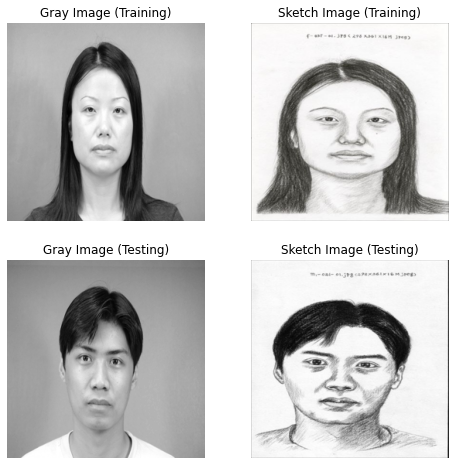

In [113]:
#@title **2.2. Comparison of Converted Gray Images to Sketch Images**


def image_comparisons(x_train, y_train, x_test, y_test):
    # Select a random index from the training set
    rand_train_index = np.random.randint(0, len(x_train))
    # Select a random index from the testing set
    rand_test_index = np.random.randint(0, len(x_test))

    # Create a figure with two rows and two columns of subplots
    fig, axs = plt.subplots(2, 2, figsize=(8, 8))

    # Display the gray image from the training set
    axs[0, 0].imshow(x_train[rand_train_index].reshape(256, 256), cmap='gray')
    axs[0, 0].set_title('Gray Image (Training)')
    axs[0, 0].axis('off')
    # Display the corresponding sketch image from the training set
    axs[0, 1].imshow(y_train[rand_train_index])
    axs[0, 1].set_title('Sketch Image (Training)')
    axs[0, 1].axis('off')

    # Display the gray image from the testing set
    axs[1, 0].imshow(x_test[rand_test_index].reshape(256, 256), cmap='gray')
    axs[1, 0].set_title('Gray Image (Testing)')
    axs[1, 0].axis('off')
    # Display the corresponding sketch image from the testing set
    axs[1, 1].imshow(y_test[rand_test_index])
    axs[1, 1].set_title('Sketch Image (Testing)')
    axs[1, 1].axis('off')

    plt.show()

image_comparisons(x_train_photo, y_train_sketch, x_test_photo, y_test_sketch)

In [114]:
#@title **2.2. Convert Gray Images into Sketch Images**

import cv2

# Create empty lists to store the sketch images
x_train_sketch = []
x_test_sketch = []

# Loop through each image in x_train_photo and x_test_photo, and convert to sketch
for img in x_train_photo:
    # Convert the image to uint8 format
    img = (img * 255).astype('uint8')
    
    # Apply Canny edge detection algorithm
    edges = cv2.Canny(img, 100, 200)
    
    # Invert the pixel values
    edges = 255 - edges
    
    # Convert the image back to float32 format and normalize
    edges = edges.astype('float32') / 255.
    
    # Reshape the image array to match the original format
    edges = edges.reshape(img.shape[0], img.shape[1], 1)
    
    # Add the sketch image to the list
    x_train_sketch.append(edges)

for img in x_test_photo:
    # Convert the image to uint8 format
    img = (img * 255).astype('uint8')
    
    # Apply Canny edge detection algorithm
    edges = cv2.Canny(img, 100, 200)
    
    # Invert the pixel values
    edges = 255 - edges
    
    # Convert the image back to float32 format and normalize
    edges = edges.astype('float32') / 255.
    
    # Reshape the image array to match the original format
    edges = edges.reshape(img.shape[0], img.shape[1], 1)
    
    # Add the sketch image to the list
    x_test_sketch.append(edges)

# Convert the lists of sketch images to numpy arrays
x_train_sketch = np.array(x_train_sketch)
x_test_sketch = np.array(x_test_sketch)

# Print the shapes of the new datasets
print(f"Training Dataset (Face2Sketch): {x_train_sketch.shape}")
print(f"Testing Dataset (Face2Sketch): {x_test_sketch.shape}")

Training dataset (Face2Sketch): (88, 256, 256, 1)
Testing dataset (Face2Sketch): (100, 256, 256, 1)


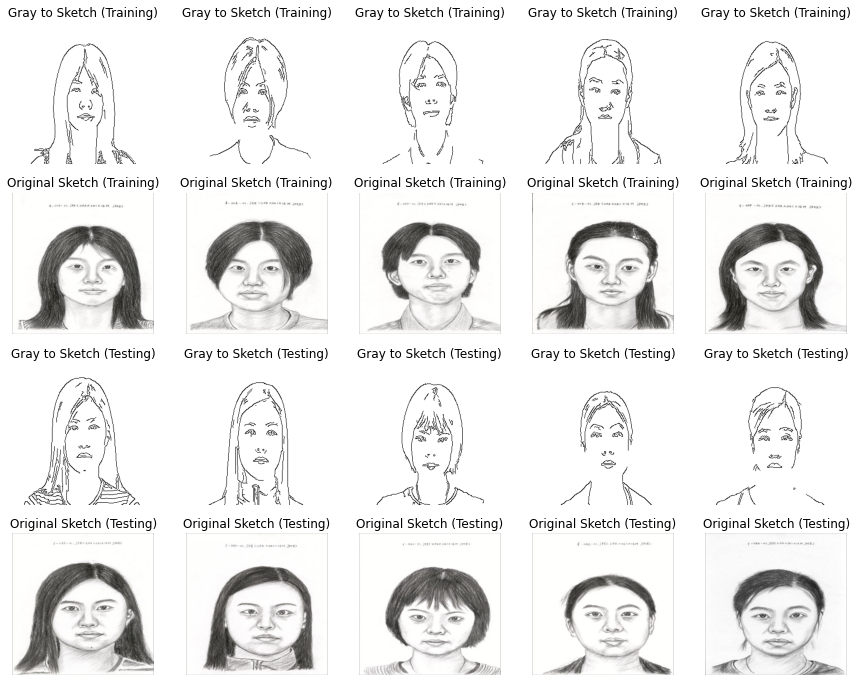

In [115]:
#@title **2.3. Comparison of Face2Sketch Images to the Original Sketch**


# Display the first 5 images from x_train_sketch and x_test_sketch as well as y_train_sketch and y_test_sketch
fig, ax = plt.subplots(nrows=4, ncols=5, figsize=(15, 12))

for i in range(5):
    ax[0, i].imshow(x_train_sketch[i].reshape(256, 256), cmap='gray')
    ax[0, i].axis('off')
    ax[0, i].set_title("Face2Sketch (Training)")
    
    ax[1, i].imshow(y_train_sketch[i])
    ax[1, i].axis('off')
    ax[1, i].set_title("Original Sketch (Training)")
    
    ax[2, i].imshow(x_test_sketch[i].reshape(256, 256), cmap='gray')
    ax[2, i].axis('off')
    ax[2, i].set_title("Face2Sketch (Testing)")
    
    ax[3, i].imshow(y_test_sketch[i])
    ax[3, i].axis('off')
    ax[3, i].set_title("Original Sketch (Testing)")

plt.show()

In [120]:
#@title **2.4. Structural Similarity Index Measure Metric Comparison (SSIM)**


from skimage.metrics import structural_similarity as ssim

def compare_sketch_accuracy(sketch_images, original_images):
    total_ssim = 0
    
    for i in range(len(sketch_images)):
        sketch_image = sketch_images[i].reshape(256, 256)
        original_image = original_images[i].reshape(256, 256)
        similarity = ssim(sketch_image, original_image, channel_axis=True)
        total_ssim += similarity
    
    avg_ssim = total_ssim / len(sketch_images)
    
    return avg_ssim


train_ssim = compare_sketch_accuracy(x_train_sketch, y_train_sketch)
test_ssim = compare_sketch_accuracy(x_test_sketch, y_test_sketch)

print(f"Average SSIM Between Converted Sketch Images and Original Sketch Images (Training Set): {round(train_ssim * 100, 3)} %")
print(f"Average SSIM Between Converted Sketch Images and Original Sketch Images (Testing Set): {round(test_ssim * 100, 3)} %")

Average SSIM Between Converted Sketch Images and Original Sketch Images (Training Set): 69.179 %
Average SSIM Between Converted Sketch Images and Original Sketch Images (Testing Set): 66.939 %


# **3.0. Sketch2Face Implementation (AutoEncoders)**

In [146]:
#@title **3.1. Load and Pre-Process the Datasets Containing Sketch Images**


def load_sketches(directory):
    sketches = []
    for root, dirs, files in os.walk(directory):
        if 'sketch' in root.lower():
            files = sorted(files)  # sort the list of filenames
            for filename in files:
                if filename.lower().endswith(".jpg"):
                    img_path = os.path.join(root, filename)
                    img = Image.open(img_path).convert('L') # L = Grey scale, RGB = RGB
                    img = img.resize((256, 256))
                    img_array = np.array(img)
                    img_array = img_array.reshape(256, 256, 1)  # 1 = Grey scale, 3 = RGB (Red, Green, Blue)
                    sketches.append(img_array)
    return sketches


# Load the images and preprocess them
y_train_sketch = np.array(load_sketches("train_sketch"))
y_test_sketch = np.array(load_sketches("test_sketch"))

# Convert the pixel values to floats between 0 and 1
y_train_sketch = y_train_sketch.astype('float32') / 255.
y_test_sketch = y_test_sketch.astype('float32') / 255.

print(f"Training Dataset (Sketch): {y_train_sketch.shape}", f"Testing Dataset (Sketch): {y_test_sketch.shape}")

Training Dataset (Sketch): (88, 256, 256, 1) Testing Dataset (Sketch): (100, 256, 256, 1)


In [147]:
#@title **3.2. Reset the Converted Sketch Images to RGB Images**


def load_images(directory):
    images = []
    for root, dirs, files in os.walk(directory):
        if 'photo' in root.lower():
            files = sorted(files)  # sort the list of filenames
            for filename in files:
                if filename.lower().endswith(".jpg"):
                    img_path = os.path.join(root, filename)
                    img = Image.open(img_path).convert('RGB') # L = Grey scale, RGB = RGB
                    img = img.resize((256, 256))
                    img_array = np.array(img)
                    img_array = img_array.reshape(256, 256, 3)  # 1 = Grey scale, 3 = RGB (Red, Green, Blue)
                    images.append(img_array)
    return images


# Load the images and preprocess them
x_train_photo = np.array(load_images("train_photo"))
x_test_photo = np.array(load_images("test_photo"))

# Convert the pixel values to floats between 0 and 1
x_train_photo = x_train_photo.astype('float32') / 255.
x_test_photo = x_test_photo.astype('float32') / 255.

print(f"Training Dataset (Photo): {x_train_photo.shape}", f"Testing Dataset (Photo): {x_test_photo.shape}")

Training Dataset (Photo): (88, 256, 256, 3) Testing Dataset (Photo): (100, 256, 256, 3)


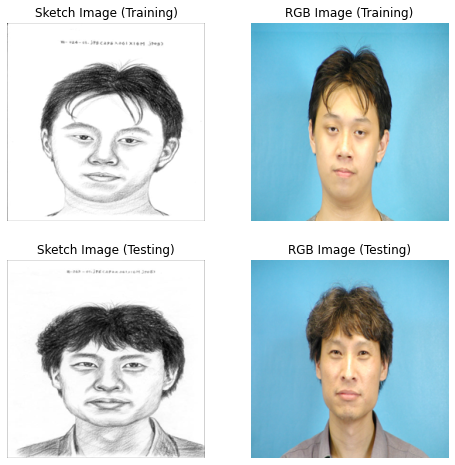

In [123]:
#@title **3.3. Comparison of Sketch Images to RGB Images**


def sketch_comparisons(y_train, x_train, y_test, x_test):
    # Select a random index from the training set
    rand_train_index = np.random.randint(0, len(y_train))
    # Select a random index from the testing set
    rand_test_index = np.random.randint(0, len(y_test))

    # Create a figure with two rows and two columns of subplots
    fig, axs = plt.subplots(2, 2, figsize=(8, 8))

    # Display the gray image from the training set
    axs[0, 0].imshow(y_train[rand_train_index].reshape(256, 256), cmap='gray')
    axs[0, 0].set_title('Sketch Image (Training)')
    axs[0, 0].axis('off')
    # Display the corresponding sketch image from the training set
    axs[0, 1].imshow(x_train[rand_train_index])
    axs[0, 1].set_title('RGB Image (Training)')
    axs[0, 1].axis('off')

    # Display the gray image from the testing set
    axs[1, 0].imshow(y_test[rand_test_index].reshape(256, 256), cmap='gray')
    axs[1, 0].set_title('Sketch Image (Testing)')
    axs[1, 0].axis('off')
    # Display the corresponding sketch image from the testing set
    axs[1, 1].imshow(x_test[rand_test_index])
    axs[1, 1].set_title('RGB Image (Testing)')
    axs[1, 1].axis('off')

    plt.show()


sketch_comparisons(y_train_sketch, x_train_photo, y_test_sketch, x_test_photo)

In [159]:
#@title **3.4. Convert Sketch Images into RGB Images**


import cv2

# Create empty lists to store the RGB images
y_train_photo = []
y_test_photo = []

# Loop through each image in y_train_sketch and y_test_sketch, and add color using the corresponding original RGB image
for i in range(len(y_train_sketch)):
    # Convert the sketch image to uint8 format
    sketch = (y_train_sketch[i] * 255).astype('uint8')
    
    # Load the corresponding original RGB image
    rgb = x_train_photo[i]
    
    # Resize the original RGB image to match the size of the sketch image
    rgb_resized = cv2.resize(rgb, (sketch.shape[1], sketch.shape[0]))
    
    # Create a mask by thresholding the sketch image
    mask = (sketch > 0.5).astype('float32')
    
    # Expand the mask to 3 channels
    mask = np.repeat(mask, 3, axis=2)
    
    # Combine the mask and the original RGB image to create a colorized image
    color = mask * rgb_resized + (1 - mask) * sketch
    
    # Normalize the pixel values to the range [0, 255]
    color = color * 255.0

    # Convert to uint8 format
    color = color.astype('uint8')
    
    # Add the colorized image to the list
    y_train_photo.append(color)

for i in range(len(y_test_sketch)):
    # Convert the sketch image to uint8 format
    sketch = (y_test_sketch[i] * 255).astype('uint8')
    
    # Load the corresponding original RGB image
    rgb = x_test_photo[i]
    
    # Resize the original RGB image to match the size of the sketch image
    rgb_resized = cv2.resize(rgb, (sketch.shape[1], sketch.shape[0]))
    
    # Create a mask by thresholding the sketch image
    mask = (sketch > 0.5).astype('float32')
    
    # Expand the mask to 3 channels
    mask = np.repeat(mask, 3, axis=2)
    
    # Combine the mask and the original RGB image to create a colorized image
    color = mask * rgb_resized + (1 - mask) * sketch
    
    # Normalize the pixel values to the range [0, 255]
    color = color * 255.0

    # Convert to uint8 format
    color = color.astype('uint8')
    
    # Add the colorized image to the list
    y_test_photo.append(color)

# Convert the lists of colored images to numpy arrays
y_train_photo = np.array(y_train_photo)
y_test_photo = np.array(y_test_photo)

# Print the shapes of the new datasets
print(f"Training Dataset (Sketch2Face): {y_train_photo.shape}")
print(f"Testing Dataset (Sketch2Face): {y_test_photo.shape}")

Training Dataset (Sketch2Face): (88, 256, 256, 3)
Testing Dataset (Sketch2Face): (100, 256, 256, 3)


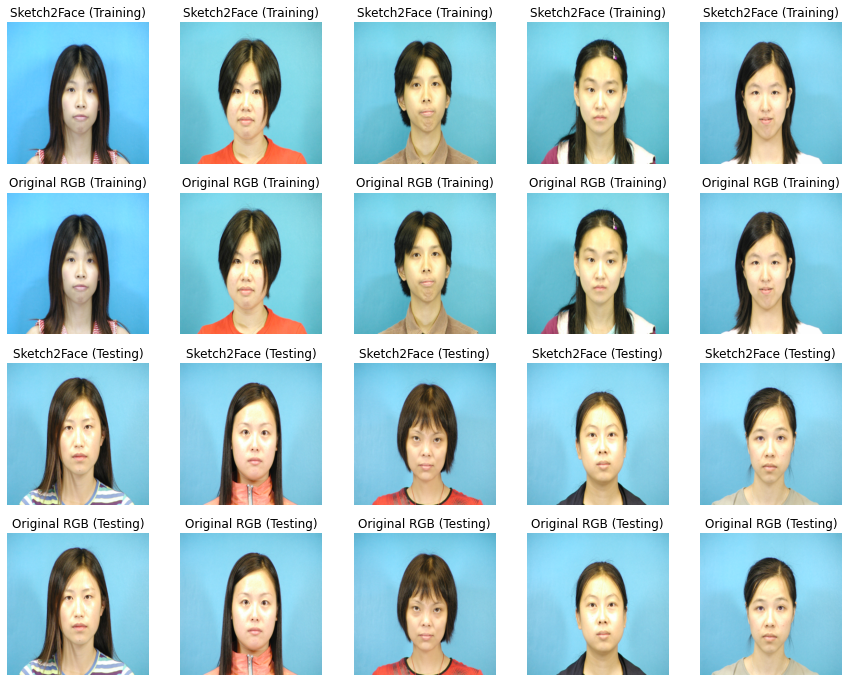

In [161]:
#@title **3.5. Comparison of Sketch2Face Images to the RGB Images**


# Display the first 5 images from y_train_photo and y_test_photo as well as x_train_photo and x_test_photo
def compare_images(y_train_photo, x_train_photo, y_test_photo, x_test_photo):
    fig, ax = plt.subplots(nrows=4, ncols=5, figsize=(15, 12))

    for i in range(5):
        ax[0, i].imshow(y_train_photo[i])
        ax[0, i].axis('off')
        ax[0, i].set_title("Sketch2Face (Training)")

        ax[1, i].imshow(x_train_photo[i])
        ax[1, i].axis('off')
        ax[1, i].set_title("Original RGB (Training)")

        ax[2, i].imshow(y_test_photo[i])
        ax[2, i].axis('off')
        ax[2, i].set_title("Sketch2Face (Testing)")

        ax[3, i].imshow(x_test_photo[i])
        ax[3, i].axis('off')
        ax[3, i].set_title("Original RGB (Testing)")

    plt.show()

compare_images(y_train_photo, x_train_photo, y_test_photo, x_test_photo)